In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colormaps
import sys

sys.path.append("../../../../XRaySimulation")
from XRaySimulation import util, RockingCurve, Pulse

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

In [2]:
np.rad2deg(np.arctan((300 * 200e-6) / 4.362))

0.7880628113594065

In [3]:
def get_rotmat_around_axis(angleRadian, axis):
    """
    Get a rotation matrix that rotate a vector
    with respect to an axis by some angle in radian.

    According to the right hand rule,
    if one aligns the thumb with the positive direction of the axis,
    then a positive angle is direction of your four fingers with
    a hollow fist.

    :param angleRadian:
    :param axis:
    :return:
    """

    # Check the axis length and normalize it
    if np.linalg.norm(axis) < 1e-6:
        print("The axis has to be a vector of unit length.")
        return False
    axis /= np.linalg.norm(axis)

    # Step 1: get a vector that is not parallel with the axis
    new_axis = np.zeros(3, dtype=np.float64)
    new_axis[0] = 1.0

    if np.linalg.norm(np.cross(new_axis, axis)) <= 1e-8:
        # If this relative is valid, then axis[0] ~ 1 while  axis[1] = axis[2] = 0
        new_axis[0] = 0.0
        new_axis[1] = 1.0

    # print(newAxis)

    # Step 2: remove the projection of the newAxis on the axis direction
    new_axis -= axis * np.dot(axis, new_axis)
    new_axis /= np.linalg.norm(new_axis)

    # print(newAxis)

    # Step 2: get the other vector though cross project
    new_axis2 = np.cross(axis, new_axis)

    # Construct the matrix
    rotMat = np.zeros((3, 3))
    rotMat += np.outer(axis, axis) + np.cos(angleRadian) * (
            np.outer(new_axis, new_axis) + np.outer(new_axis2, new_axis2))
    rotMat += np.sin(angleRadian) * (np.outer(new_axis2, new_axis) - np.outer(new_axis, new_axis2))

    return rotMat


In [4]:
kVec = np.array([-0.11689482, -1.97294018, 4.55617549])
kLen = np.linalg.norm(kVec)

# Get the reciprocal lattice of STO 220
gVec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / 1.3806

# Rotate the crystal to get a circle
angle_num = 10000
angle_list = np.linspace(start=np.deg2rad(-2.9004 - 1), stop=np.deg2rad(-2.9004 + 1), num=angle_num)

tilt_angle = np.deg2rad(11.5)
tilt_mat = np.array([[np.cos(tilt_angle), 0, np.sin(tilt_angle)],
                     [0, 1, 0],
                     [-np.sin(tilt_angle), 0, np.cos(tilt_angle)], ])

gVec_list = np.zeros((angle_num, 3))
for idx in range(angle_num):
    angle_rot = angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)], ])

    gVec_list[idx, :] = np.dot(tilt_mat, np.dot(rot_mat, gVec))

# Get the transient grating wavevector
tVec = np.array([1, 0, 0]) * kLen * np.sin(np.deg2rad(0.1567 * 2 - 7e-3)) * 2

In [17]:
tVec = np.array([1, 0, 0]) * kLen * np.sin(np.deg2rad(0.1 * 2)) * 2
print(np.pi * 2 / tVec[0] / 10)

18.12190203674962


In [6]:
0.2 * 2 - 7e-3

0.393

In [76]:
# Get the geometric Bragg angle position
kout = gVec_list + kVec[np.newaxis, :]
kout_len = np.linalg.norm(kout, axis=-1)
kout_len_diff = kout_len - kLen
bragg_idx = np.argmin(np.abs(kout_len_diff))

kout_tg = gVec_list + kVec[np.newaxis, :] + tVec[np.newaxis, :]
kout_len_tg = np.linalg.norm(kout_tg, axis=-1)
kout_len_diff_tg = kout_len_tg - kLen
tg_idx = np.argmin(np.abs(kout_len_diff_tg))

kout_tg1 = gVec_list + kVec[np.newaxis, :] - tVec[np.newaxis, :]
kout_len_tg1 = np.linalg.norm(kout_tg1, axis=-1)
kout_len_diff_tg1 = kout_len_tg1 - kLen
tg1_idx = np.argmin(np.abs(kout_len_diff_tg1))

bragg_angle = angle_list[bragg_idx]
tg_angle = angle_list[tg_idx]
tg1_angle = angle_list[tg1_idx]

print("The Bragg angle is at {:.4f} deg".format(np.rad2deg(bragg_angle)))
#print(kout[bragg_idx] / kout[bragg_idx][-1])

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(tg_angle)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(tg_angle)))
#print(kout_tg[tg_idx] / kout_tg[tg_idx][-1])

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(tg1_angle)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(tg1_angle)))
#print(kout_tg1[tg1_idx] / kout_tg1[tg1_idx][-1])

The Bragg angle is at -2.9009 deg
The Bragg angle with TG is at -3.5622 deg
The angular difference is 0.6613 deg
The Bragg angle with TG is at -2.2516 deg
The angular difference is -0.6493 deg


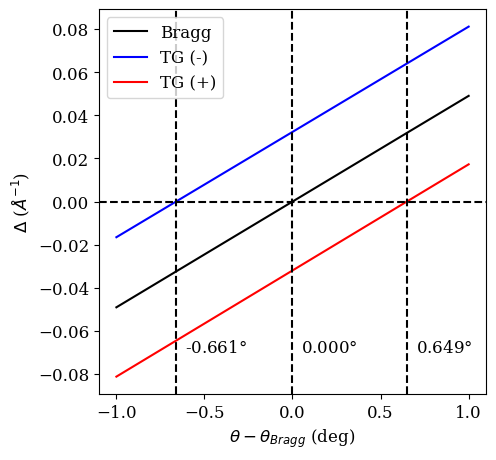

In [77]:
fig, ax = plt.subplots(ncols=1, nrows=1)
cmap = colormaps['summer']

fig.set_figheight(5)
fig.set_figwidth(5)

ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff, c='k', label="Bragg")
ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff_tg, c='b', label='TG (-)')
ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff_tg1, c='r', label='TG (+)')
ax.axhline(y=0, linestyle='--', c='k')
ax.axvline(x=np.rad2deg(bragg_angle - bragg_angle), linestyle='--', c='k')
ax.axvline(x=np.rad2deg(tg_angle - bragg_angle), linestyle='--', c='k')
ax.axvline(x=np.rad2deg(tg1_angle - bragg_angle), linestyle='--', c='k')
ax.text(x=np.rad2deg(bragg_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(bragg_angle - bragg_angle)), )
ax.text(x=np.rad2deg(tg_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(tg_angle - bragg_angle)), )
ax.text(x=np.rad2deg(tg1_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(tg1_angle - bragg_angle)), )

ax.set_ylabel("$\Delta$ ($\AA^{-1}$)")
ax.set_xlabel(r'$\theta - \theta_{Bragg}$ (deg)')
plt.legend()
plt.savefig("./phase_matching_calculation.png", dpi=300, bbox_inches='tight')
plt.show()

In [79]:
kVec

array([-0.11689482, -1.97294018,  4.55617549])

In [80]:
0.1567 * 2 - 7e-3

0.3064